In [1]:
# # -*- coding: utf-8 -*-
# import torch
# import math
# import numpy as np

# # Create Tensors to hold input and outputs.
# x = torch.linspace(-math.pi, math.pi, 2000)
# y = torch.sin(x)

# # For this example, the output y is a linear function of (x, x^2, x^3), so
# # we can consider it as a linear layer neural network. Let's prepare the
# # tensor (x, x^2, x^3).
# p = torch.tensor([1, 2, 3])
# xx = x.unsqueeze(-1).pow(p)

# # In the above code, x.unsqueeze(-1) has shape (2000, 1), and p has shape
# # (3,), for this case, broadcasting semantics will apply to obtain a tensor
# # of shape (2000, 3) 

# # Use the nn package to define our model as a sequence of layers. nn.Sequential
# # is a Module which contains other Modules, and applies them in sequence to
# # produce its output. The Linear Module computes output from input using a
# # linear function, and holds internal Tensors for its weight and bias.
# # The Flatten layer flatens the output of the linear layer to a 1D tensor,
# # to match the shape of `y`.
# model = torch.nn.Sequential(
#     torch.nn.Linear(3, 1),
#     torch.nn.Flatten(0, 1)
# )

# # The nn package also contains definitions of popular loss functions; in this
# # case we will use Mean Squared Error (MSE) as our loss function.
# loss_fn = torch.nn.MSELoss(reduction='sum')

# learning_rate = 1e-6
# for t in range(2000):

#     # Forward pass: compute predicted y by passing x to the model. Module objects
#     # override the __call__ operator so you can call them like functions. When
#     # doing so you pass a Tensor of input data to the Module and it produces
#     # a Tensor of output data.
#     y_pred = model(xx)

#     # Compute and print loss. We pass Tensors containing the predicted and true
#     # values of y, and the loss function returns a Tensor containing the
#     # loss.
#     loss = loss_fn(y_pred, y)
#     if t % 100 == 99:
#         print(t, loss.item())

#     # Zero the gradients before running the backward pass.
#     model.zero_grad()

#     # Backward pass: compute gradient of the loss with respect to all the learnable
#     # parameters of the model. Internally, the parameters of each Module are stored
#     # in Tensors with requires_grad=True, so this call will compute gradients for
#     # all learnable parameters in the model.
#     loss.backward()

#     # Update the weights using gradient descent. Each parameter is a Tensor, so
#     # we can access its gradients like we did before.
#     with torch.no_grad():
#         for param in model.parameters():
#             param -= learning_rate * param.grad

# # You can access the first layer of `model` like accessing the first item of a list
# linear_layer = model[0]

# # For linear layer, its parameters are stored as `weight` and `bias`.
# print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import math
'''DATA'''

# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

# For this example, the output y is a linear function of (x, x^2, x^3), so
# we can consider it as a linear layer neural network. Let's prepare the
# tensor (x, x^2, x^3).
p = torch.tensor([1, 2, 3])
xx = x.unsqueeze(-1).pow(p)

# In the above code, x.unsqueeze(-1) has shape (2000, 1), and p has shape
# (3,), for this case, broadcasting semantics will apply to obtain a tensor
# of shape (2000, 3) 
train_ds = TensorDataset(xx, y)
val_ds = TensorDataset(xx, y)
train_ds[0]


/Users/rrossmil/.venv/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(tensor([ -3.1416,   9.8696, -31.0063]), tensor(8.7423e-08))

In [3]:
from sklearn.model_selection import train_test_split
'''DATASETS'''

x_train, x_test, y_train, y_test = train_test_split(
    xx, y, test_size=0.33, random_state=42
)

bs = 32
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_test, y_test)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(3, 1), nn.Sigmoid(), nn.Flatten(0, 1))

    def forward(self, x):
        return self.model(x)

In [28]:
def train(train_dl, valid_dl, model, epochs):
    learning_rate = 1e-2

    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=1e-5
    )
    history = []
    early_stop = 0
    for e in range(epochs):
        model.train()
        for x, y in train_dl:
            # Forward
            pred = model(x)

            # Compute loss
            # Note that you should only compute the losses of the nodes in the training set.

            loss = F.mse_loss(pred, y)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # end batch

        model.eval()
        with torch.no_grad():
            valid_loss = sum(F.mse_loss(model(xb), yb) for xb, yb in valid_dl)
            valid_loss = valid_loss / len(valid_dl)

        history.append(
            [
                loss.item(),
                valid_loss.item(),
            ]
        )

        if e % 100 == 0:
            val_acc = 0
            print(f"Epoch {e}, loss: {loss:.3f}, valid_loss {valid_loss:.3f}")

    return history


# model = GCN(g.ndata["x"].shape[1], 64, g.ndata["label"].unique().shape[0])
model = NN()
history = train(train_dl, valid_dl, model, epochs=10_000)


Epoch 0, loss: 0.100, valid_loss 0.116
Epoch 100, loss: 0.004, valid_loss 0.005
Epoch 200, loss: 0.005, valid_loss 0.006
Epoch 300, loss: 0.004, valid_loss 0.004
Epoch 400, loss: 0.005, valid_loss 0.005
Epoch 500, loss: 0.006, valid_loss 0.006
Epoch 600, loss: 0.004, valid_loss 0.005
Epoch 700, loss: 0.005, valid_loss 0.004
Epoch 800, loss: 0.010, valid_loss 0.004
Epoch 900, loss: 0.004, valid_loss 0.004
Epoch 1000, loss: 0.007, valid_loss 0.005
Epoch 1100, loss: 0.003, valid_loss 0.006
Epoch 1200, loss: 0.006, valid_loss 0.004
Epoch 1300, loss: 0.009, valid_loss 0.005
Epoch 1400, loss: 0.004, valid_loss 0.005
Epoch 1500, loss: 0.006, valid_loss 0.005
Epoch 1600, loss: 0.006, valid_loss 0.007
Epoch 1700, loss: 0.004, valid_loss 0.005
Epoch 1800, loss: 0.006, valid_loss 0.005
Epoch 1900, loss: 0.011, valid_loss 0.007
Epoch 2000, loss: 0.005, valid_loss 0.009
Epoch 2100, loss: 0.006, valid_loss 0.005
Epoch 2200, loss: 0.007, valid_loss 0.006
Epoch 2300, loss: 0.006, valid_loss 0.009
Epoc

loss          float64
valid_loss    float64
dtype: object


,loss,valid_loss
0,0.100190,0.115958
1,0.043893,0.040306
2,0.011470,0.013075
3,0.005920,0.005768
4,0.003879,0.004571


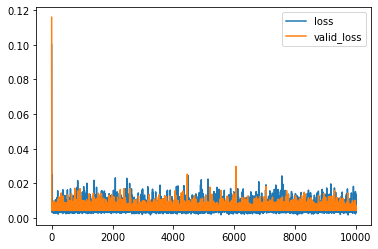

In [29]:
import pandas as pd
df = pd.DataFrame(history, columns=['loss','valid_loss'])
print(df.dtypes)
df[['loss','valid_loss']].plot()
df.head()

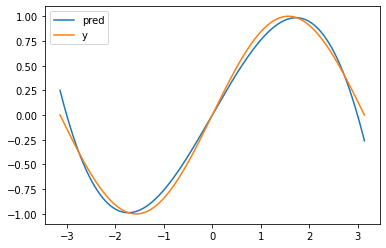

In [30]:
import matplotlib.pyplot as plt

model.eval()
p = model(xx)

fig, ax = plt.subplots()
ax.plot(xx[:, 0], p.detach().numpy(), label='pred')
ax.plot(xx[:, 0], y, label='y')
plt.legend()
